# 07 - Convolutional Neural Networks from Scratch

## Learning Objectives

By the end of this notebook, you will:

1. **Understand convolution operations** - How filters slide over images, padding, stride, dilation
2. **Master pooling layers** - Max pooling, average pooling, global pooling, adaptive pooling
3. **Build CNN architectures** - From simple ConvNets to ResNet with skip connections
4. **Implement key components** - Batch normalization, dropout, residual blocks
5. **Train CNNs effectively** - Data augmentation, learning rate schedules, regularization

---

## Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional
import math

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")

torch.manual_seed(42)
np.random.seed(42)

Using device: cuda
GPU: NVIDIA RTX A2000 Laptop GPU


---

## 1. Understanding Convolutions

### 1.1 What is a Convolution?

A convolution slides a small filter (kernel) across an image, computing dot products at each position. This creates a feature map that detects specific patterns.

In [2]:
# Manual 2D convolution to understand the operation

def manual_conv2d(image: torch.Tensor, kernel: torch.Tensor) -> torch.Tensor:
    """
    Manual implementation of 2D convolution (no padding, stride=1).
    
    Args:
        image: (H, W) tensor
        kernel: (kH, kW) tensor
    
    Returns:
        (H-kH+1, W-kW+1) tensor
    """
    h, w = image.shape
    kh, kw = kernel.shape
    
    out_h = h - kh + 1
    out_w = w - kw + 1
    
    output = torch.zeros(out_h, out_w)
    
    for i in range(out_h):
        for j in range(out_w):
            # Extract patch and compute dot product with kernel
            patch = image[i:i+kh, j:j+kw]
            output[i, j] = (patch * kernel).sum()
    
    return output


# Create a simple image and kernel
image = torch.tensor([
    [1, 2, 3, 0, 1],
    [0, 1, 2, 3, 1],
    [1, 2, 1, 0, 0],
    [2, 1, 0, 1, 1],
    [1, 0, 1, 2, 1]
], dtype=torch.float32)

# Edge detection kernel (Sobel-like)
kernel = torch.tensor([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=torch.float32)

output = manual_conv2d(image, kernel)
print(f"Input shape: {image.shape}")
print(f"Kernel shape: {kernel.shape}")
print(f"Output shape: {output.shape}")
print(f"\nOutput:\n{output}")

Input shape: torch.Size([5, 5])
Kernel shape: torch.Size([3, 3])
Output shape: torch.Size([3, 3])

Output:
tensor([[ 6.,  0., -5.],
        [ 0., -2., -2.],
        [-4.,  0.,  1.]])


In [3]:
# Verify with PyTorch's conv2d
# F.conv2d expects (N, C, H, W) input and (out_channels, in_channels, kH, kW) kernel

image_4d = image.unsqueeze(0).unsqueeze(0)  # (1, 1, 5, 5)
kernel_4d = kernel.unsqueeze(0).unsqueeze(0)  # (1, 1, 3, 3)

pytorch_output = F.conv2d(image_4d, kernel_4d)
print(f"PyTorch output:\n{pytorch_output.squeeze()}")
print(f"\nMatches manual: {torch.allclose(output, pytorch_output.squeeze())}")

PyTorch output:
tensor([[ 6.,  0., -5.],
        [ 0., -2., -2.],
        [-4.,  0.,  1.]])

Matches manual: True


### 1.2 Padding, Stride, and Dilation

These parameters control the convolution's behavior:

- **Padding**: Add zeros around the input to preserve spatial dimensions
- **Stride**: How many pixels the kernel moves at each step
- **Dilation**: Spacing between kernel elements (for larger receptive fields)

In [4]:
def calc_output_size(input_size: int, kernel_size: int, padding: int = 0, 
                     stride: int = 1, dilation: int = 1) -> int:
    """
    Calculate output size of a convolution.
    
    Formula: out = floor((in + 2*pad - dil*(k-1) - 1) / stride + 1)
    """
    effective_kernel = dilation * (kernel_size - 1) + 1
    return (input_size + 2 * padding - effective_kernel) // stride + 1


# Examples
print("Output size calculations:")
print(f"Input=32, kernel=3, padding=0, stride=1: {calc_output_size(32, 3, 0, 1)}")
print(f"Input=32, kernel=3, padding=1, stride=1: {calc_output_size(32, 3, 1, 1)} (same padding)")
print(f"Input=32, kernel=3, padding=1, stride=2: {calc_output_size(32, 3, 1, 2)} (downsampling)")
print(f"Input=32, kernel=3, padding=2, stride=1, dilation=2: {calc_output_size(32, 3, 2, 1, 2)}")

Output size calculations:
Input=32, kernel=3, padding=0, stride=1: 30
Input=32, kernel=3, padding=1, stride=1: 32 (same padding)
Input=32, kernel=3, padding=1, stride=2: 16 (downsampling)
Input=32, kernel=3, padding=2, stride=1, dilation=2: 32


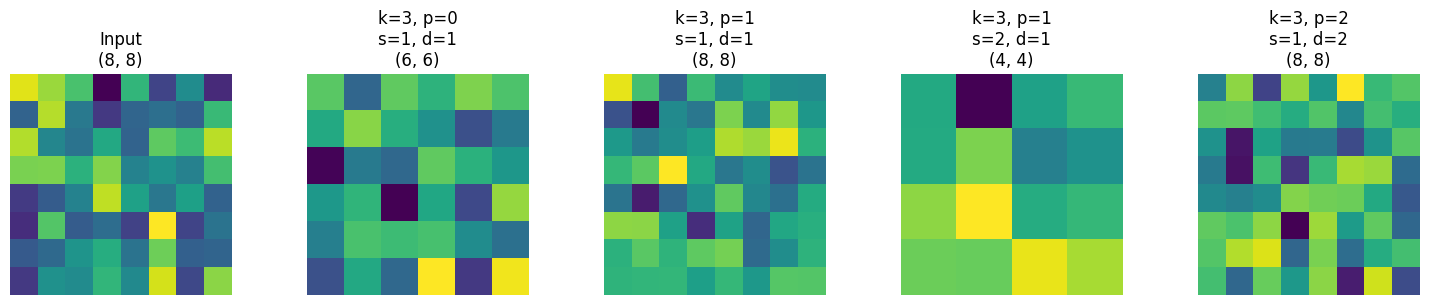

In [5]:
# Visualize the effect of different parameters

def visualize_conv_params():
    x = torch.randn(1, 1, 8, 8)
    
    configs = [
        {'kernel_size': 3, 'padding': 0, 'stride': 1, 'dilation': 1},
        {'kernel_size': 3, 'padding': 1, 'stride': 1, 'dilation': 1},  # Same padding
        {'kernel_size': 3, 'padding': 1, 'stride': 2, 'dilation': 1},  # Downsampling
        {'kernel_size': 3, 'padding': 2, 'stride': 1, 'dilation': 2},  # Dilated
    ]
    
    fig, axes = plt.subplots(1, len(configs) + 1, figsize=(15, 3))
    
    axes[0].imshow(x.squeeze(), cmap='viridis')
    axes[0].set_title(f'Input\n{tuple(x.shape[2:])}')
    axes[0].axis('off')
    
    for i, cfg in enumerate(configs):
        conv = nn.Conv2d(1, 1, **cfg)
        out = conv(x)
        axes[i+1].imshow(out.detach().squeeze(), cmap='viridis')
        title = f"k={cfg['kernel_size']}, p={cfg['padding']}\ns={cfg['stride']}, d={cfg['dilation']}\n{tuple(out.shape[2:])}"
        axes[i+1].set_title(title)
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_conv_params()

### 1.3 Multiple Channels

Real convolutions work with multiple input and output channels:
- **Input channels**: e.g., RGB = 3 channels
- **Output channels**: Each output channel is a different learned filter

In [6]:
# Understanding multi-channel convolutions

# Conv2d with 3 input channels (RGB) and 16 output channels
conv = nn.Conv2d(
    in_channels=3,
    out_channels=16,
    kernel_size=3,
    padding=1
)

print(f"Weight shape: {conv.weight.shape}")  # (out_ch, in_ch, kH, kW)
print(f"Bias shape: {conv.bias.shape}")  # (out_ch,)

# Total parameters
num_params = conv.weight.numel() + conv.bias.numel()
print(f"Total parameters: {num_params}")
print(f"  = {conv.out_channels} * ({conv.in_channels} * {conv.kernel_size[0]} * {conv.kernel_size[1]} + 1)")

# Forward pass
x = torch.randn(4, 3, 32, 32)  # (batch, channels, height, width)
output = conv(x)
print(f"\nInput shape: {x.shape}")
print(f"Output shape: {output.shape}")

Weight shape: torch.Size([16, 3, 3, 3])
Bias shape: torch.Size([16])
Total parameters: 448
  = 16 * (3 * 3 * 3 + 1)

Input shape: torch.Size([4, 3, 32, 32])
Output shape: torch.Size([4, 16, 32, 32])


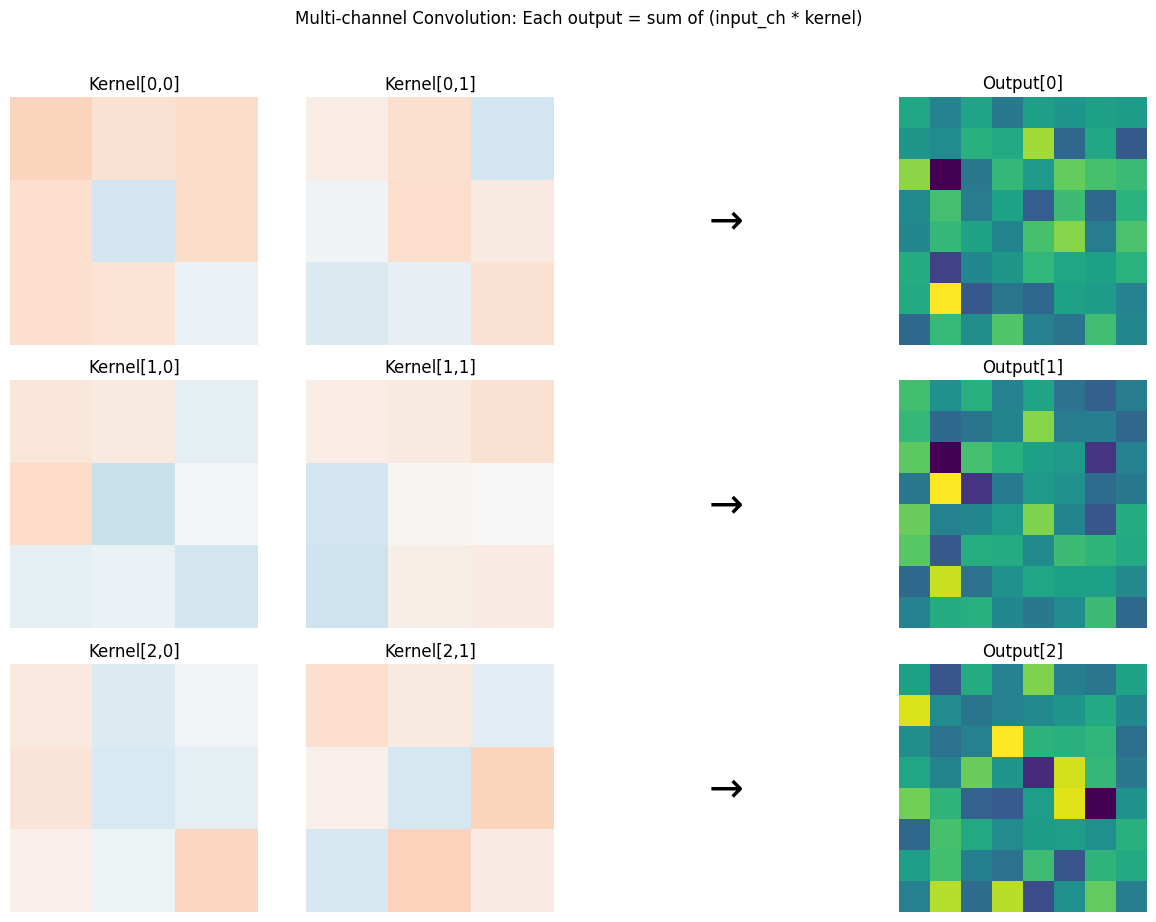

In [7]:
# Visualize what happens in multi-channel convolution

def visualize_multichannel_conv():
    """Show how each output channel is computed"""
    
    # Simple 2 in, 3 out convolution
    conv = nn.Conv2d(2, 3, kernel_size=3, padding=1, bias=False)
    
    # Input: 2 channels
    x = torch.randn(1, 2, 8, 8)
    
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    
    # For each output channel
    for out_ch in range(3):
        # Show the kernel for each input channel
        for in_ch in range(2):
            kernel = conv.weight[out_ch, in_ch].detach()
            axes[out_ch, in_ch].imshow(kernel, cmap='RdBu', vmin=-1, vmax=1)
            axes[out_ch, in_ch].set_title(f'Kernel[{out_ch},{in_ch}]')
            axes[out_ch, in_ch].axis('off')
        
        # Show the sum (what conv actually computes)
        axes[out_ch, 2].text(0.5, 0.5, '→', fontsize=30, ha='center', va='center')
        axes[out_ch, 2].axis('off')
        
        # Output channel
        output = conv(x)
        axes[out_ch, 3].imshow(output[0, out_ch].detach(), cmap='viridis')
        axes[out_ch, 3].set_title(f'Output[{out_ch}]')
        axes[out_ch, 3].axis('off')
    
    plt.suptitle('Multi-channel Convolution: Each output = sum of (input_ch * kernel)', y=1.02)
    plt.tight_layout()
    plt.show()

visualize_multichannel_conv()

### 1.4 Receptive Field

The **receptive field** is the region in the input that influences a particular output pixel. Deeper layers have larger receptive fields.

In [8]:
def calculate_receptive_field(layers: List[dict]) -> int:
    """
    Calculate the receptive field of a stack of conv layers.
    
    Each layer dict should have: kernel_size, stride, dilation
    """
    rf = 1  # Start with 1 pixel
    stride_product = 1
    
    for layer in layers:
        k = layer.get('kernel_size', 1)
        s = layer.get('stride', 1)
        d = layer.get('dilation', 1)
        
        # Effective kernel size with dilation
        effective_k = d * (k - 1) + 1
        
        # Update receptive field
        rf = rf + (effective_k - 1) * stride_product
        stride_product *= s
    
    return rf


# Example: VGG-like stack
vgg_layers = [
    {'kernel_size': 3, 'stride': 1},  # 3x3 conv
    {'kernel_size': 3, 'stride': 1},  # 3x3 conv
    {'kernel_size': 2, 'stride': 2},  # 2x2 pool
    {'kernel_size': 3, 'stride': 1},  # 3x3 conv
    {'kernel_size': 3, 'stride': 1},  # 3x3 conv
    {'kernel_size': 2, 'stride': 2},  # 2x2 pool
]

print(f"VGG-like receptive field: {calculate_receptive_field(vgg_layers)}")

# With dilated convolutions
dilated_layers = [
    {'kernel_size': 3, 'stride': 1, 'dilation': 1},
    {'kernel_size': 3, 'stride': 1, 'dilation': 2},
    {'kernel_size': 3, 'stride': 1, 'dilation': 4},
]

print(f"Dilated conv receptive field: {calculate_receptive_field(dilated_layers)}")

VGG-like receptive field: 16
Dilated conv receptive field: 15


---

## 2. Pooling Layers

Pooling reduces spatial dimensions while maintaining important features.

### 2.1 Types of Pooling

In [9]:
# Create sample feature map
x = torch.tensor([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
    [13, 14, 15, 16]
], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

print(f"Input:\n{x.squeeze()}\n")

# Max Pooling - takes maximum value in each window
max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
print(f"Max Pooling (2x2, stride 2):\n{max_pool(x).squeeze()}\n")

# Average Pooling - takes mean value in each window
avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
print(f"Average Pooling (2x2, stride 2):\n{avg_pool(x).squeeze()}\n")

# Global Average Pooling - reduces to single value per channel
global_avg_pool = nn.AdaptiveAvgPool2d(1)
print(f"Global Average Pooling:\n{global_avg_pool(x).squeeze()}")

Input:
tensor([[ 1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.]])

Max Pooling (2x2, stride 2):
tensor([[ 6.,  8.],
        [14., 16.]])

Average Pooling (2x2, stride 2):
tensor([[ 3.5000,  5.5000],
        [11.5000, 13.5000]])

Global Average Pooling:
8.5


In [10]:
# Adaptive pooling - specify output size, not kernel size

x = torch.randn(1, 3, 37, 41)  # Odd dimensions

# AdaptiveAvgPool2d automatically calculates kernel size and stride
adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))  # Always outputs 7x7
output = adaptive_pool(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print("\nAdaptive pooling is essential for handling variable input sizes!")

Input shape: torch.Size([1, 3, 37, 41])
Output shape: torch.Size([1, 3, 7, 7])

Adaptive pooling is essential for handling variable input sizes!


### 2.2 Max Pooling with Indices

In [11]:
# MaxPool2d can return indices for unpooling (used in autoencoders)

max_pool_idx = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
max_unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

x = torch.tensor([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
    [13, 14, 15, 16]
], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Pool and get indices
pooled, indices = max_pool_idx(x)
print(f"Input:\n{x.squeeze()}\n")
print(f"Pooled:\n{pooled.squeeze()}\n")
print(f"Indices (flattened positions):\n{indices.squeeze()}\n")

# Unpool using indices
unpooled = max_unpool(pooled, indices)
print(f"Unpooled:\n{unpooled.squeeze()}")

Input:
tensor([[ 1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.]])

Pooled:
tensor([[ 6.,  8.],
        [14., 16.]])

Indices (flattened positions):
tensor([[ 5,  7],
        [13, 15]])

Unpooled:
tensor([[ 0.,  0.,  0.,  0.],
        [ 0.,  6.,  0.,  8.],
        [ 0.,  0.,  0.,  0.],
        [ 0., 14.,  0., 16.]])


---

## 3. Building CNN Architectures

### 3.1 Simple CNN (LeNet-style)

In [12]:
class SimpleCNN(nn.Module):
    """
    Simple CNN architecture similar to LeNet.
    Architecture: Conv -> Pool -> Conv -> Pool -> FC -> FC -> Output
    """
    
    def __init__(self, num_classes: int = 10):
        super().__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        # After 3 pools of 2x2 on 32x32 input: 32 -> 16 -> 8 -> 4
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        # Conv block 1
        x = self.pool(F.relu(self.conv1(x)))  # 32x32 -> 16x16
        
        # Conv block 2
        x = self.pool(F.relu(self.conv2(x)))  # 16x16 -> 8x8
        
        # Conv block 3
        x = self.pool(F.relu(self.conv3(x)))  # 8x8 -> 4x4
        
        # Flatten
        x = x.flatten(1)
        
        # Fully connected
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


# Test
model = SimpleCNN(num_classes=10)
x = torch.randn(4, 3, 32, 32)
output = model(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Input shape: torch.Size([4, 3, 32, 32])
Output shape: torch.Size([4, 10])
Total parameters: 620,362


### 3.2 VGG-style CNN with Batch Normalization

In [13]:
class ConvBlock(nn.Module):
    """Conv -> BatchNorm -> ReLU block"""
    
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        return F.relu(self.bn(self.conv(x)))


class VGGStyleCNN(nn.Module):
    """
    VGG-style CNN with batch normalization.
    Uses repeated 3x3 convolutions with pooling.
    """
    
    def __init__(self, num_classes: int = 10):
        super().__init__()
        
        # Block 1: 2 convs, pool
        self.block1 = nn.Sequential(
            ConvBlock(3, 64),
            ConvBlock(64, 64),
            nn.MaxPool2d(2, 2)  # 32 -> 16
        )
        
        # Block 2: 2 convs, pool
        self.block2 = nn.Sequential(
            ConvBlock(64, 128),
            ConvBlock(128, 128),
            nn.MaxPool2d(2, 2)  # 16 -> 8
        )
        
        # Block 3: 3 convs, pool
        self.block3 = nn.Sequential(
            ConvBlock(128, 256),
            ConvBlock(256, 256),
            ConvBlock(256, 256),
            nn.MaxPool2d(2, 2)  # 8 -> 4
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global average pooling
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x


model = VGGStyleCNN(num_classes=10)
x = torch.randn(4, 3, 32, 32)
output = model(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Input shape: torch.Size([4, 3, 32, 32])
Output shape: torch.Size([4, 10])
Total parameters: 1,806,154


### 3.3 ResNet: Residual Connections

The key innovation of ResNet is the **skip connection** (residual connection), which helps train very deep networks by allowing gradients to flow directly through the network.

In [14]:
class BasicBlock(nn.Module):
    """
    Basic ResNet block with skip connection.
    
    Structure:
        x -> Conv -> BN -> ReLU -> Conv -> BN -> (+x) -> ReLU
    """
    
    expansion = 1
    
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super().__init__()
        
        # Main path
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Skip connection (identity or projection)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            # Need to match dimensions
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = x
        
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        # Add skip connection
        out += self.shortcut(identity)
        out = F.relu(out)
        
        return out


# Demonstrate the skip connection
block = BasicBlock(64, 64)
x = torch.randn(1, 64, 32, 32)
out = block(x)
print(f"BasicBlock: {x.shape} -> {out.shape}")

# With downsampling
block_down = BasicBlock(64, 128, stride=2)
out_down = block_down(x)
print(f"BasicBlock (stride=2): {x.shape} -> {out_down.shape}")

BasicBlock: torch.Size([1, 64, 32, 32]) -> torch.Size([1, 64, 32, 32])
BasicBlock (stride=2): torch.Size([1, 64, 32, 32]) -> torch.Size([1, 128, 16, 16])


In [15]:
class Bottleneck(nn.Module):
    """
    Bottleneck block for deeper ResNets (50, 101, 152).
    
    Structure:
        x -> 1x1 Conv -> 3x3 Conv -> 1x1 Conv -> (+x) -> ReLU
    
    The 1x1 convs reduce then expand channels (bottleneck).
    """
    
    expansion = 4  # Output channels = out_channels * 4
    
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super().__init__()
        
        # 1x1 conv to reduce channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # 3x3 conv (main processing)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 1x1 conv to expand channels
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        # Skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )
    
    def forward(self, x):
        identity = x
        
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        
        out += self.shortcut(identity)
        out = F.relu(out)
        
        return out


# Demonstrate bottleneck
bottleneck = Bottleneck(64, 64)
x = torch.randn(1, 64, 32, 32)
out = bottleneck(x)
print(f"Bottleneck: {x.shape} -> {out.shape}")
print(f"Note: output channels = 64 * 4 = 256")

Bottleneck: torch.Size([1, 64, 32, 32]) -> torch.Size([1, 256, 32, 32])
Note: output channels = 64 * 4 = 256


In [16]:
class ResNet(nn.Module):
    """
    ResNet implementation.
    
    Configurations:
        ResNet-18: [2, 2, 2, 2] with BasicBlock
        ResNet-34: [3, 4, 6, 3] with BasicBlock
        ResNet-50: [3, 4, 6, 3] with Bottleneck
    """
    
    def __init__(self, block, num_blocks: List[int], num_classes: int = 10):
        super().__init__()
        
        self.in_channels = 64
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Residual layers
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        # Classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        # Initialize weights
        self._initialize_weights()
    
    def _make_layer(self, block, out_channels: int, num_blocks: int, stride: int):
        """Create a layer with multiple residual blocks"""
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels * block.expansion
        
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        """Initialize weights using Kaiming initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Initial conv
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Classifier
        x = self.avgpool(x)
        x = x.flatten(1)
        x = self.fc(x)
        
        return x


def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

def ResNet34(num_classes=10):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

def ResNet50(num_classes=10):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)


# Test ResNet-18
model = ResNet18(num_classes=10)
x = torch.randn(4, 3, 32, 32)
output = model(x)
print(f"ResNet-18 Input shape: {x.shape}")
print(f"ResNet-18 Output shape: {output.shape}")
print(f"ResNet-18 Parameters: {sum(p.numel() for p in model.parameters()):,}")

ResNet-18 Input shape: torch.Size([4, 3, 32, 32])
ResNet-18 Output shape: torch.Size([4, 10])
ResNet-18 Parameters: 11,173,962


---

## 4. Training a CNN on CIFAR-10

### 4.1 Data Preparation

In [17]:
# CIFAR-10 transforms
train_transform = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load datasets
train_dataset = CIFAR10('../data', train=True, download=True, transform=train_transform)
test_dataset = CIFAR10('../data', train=False, download=True, transform=test_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

# Class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 50000
Test samples: 10000


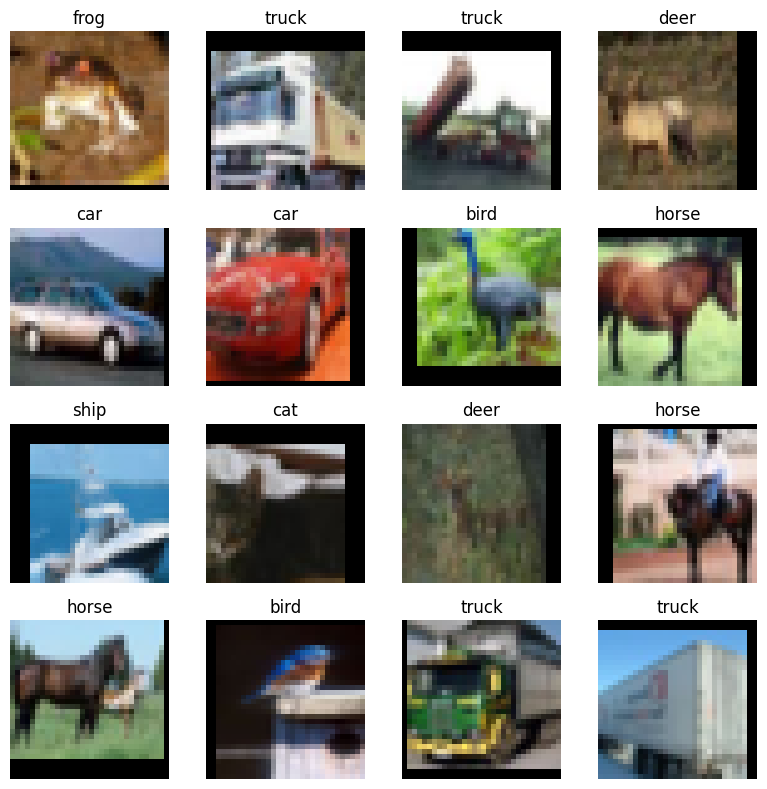

In [18]:
# Visualize some samples

def show_samples(dataset, num_samples=16):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    
    # Denormalize for visualization
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1)
    
    for i, ax in enumerate(axes.flatten()):
        img, label = dataset[i]
        img = img * std + mean  # Denormalize
        img = img.permute(1, 2, 0).clamp(0, 1)
        ax.imshow(img)
        ax.set_title(classes[label])
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

show_samples(train_dataset)

### 4.2 Training Loop

In [19]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    
    return total_loss / len(loader), 100. * correct / total


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        loss = criterion(output, target)
        
        total_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    
    return total_loss / len(loader), 100. * correct / total

In [20]:
# Train ResNet-18 on CIFAR-10

model = ResNet18(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# Training history
history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

num_epochs = 20
print(f"Training ResNet-18 for {num_epochs} epochs...")

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    
    print(f"Epoch {epoch+1:2d}/{num_epochs} | "
          f"Train Loss: {train_loss:.3f} Acc: {train_acc:.1f}% | "
          f"Test Loss: {test_loss:.3f} Acc: {test_acc:.1f}% | "
          f"LR: {scheduler.get_last_lr()[0]:.4f}")

Training ResNet-18 for 20 epochs...


KeyboardInterrupt: 

In [ ]:
# Plot training curves

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history['train_loss'], label='Train')
ax1.plot(history['test_loss'], label='Test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curves')
ax1.legend()
ax1.grid(True)

ax2.plot(history['train_acc'], label='Train')
ax2.plot(history['test_acc'], label='Test')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### 4.3 Visualize Learned Features

In [ ]:
# Visualize first layer filters

def visualize_filters(model, layer_name='conv1'):
    """Visualize the learned filters of a conv layer"""
    # Get the layer
    conv_layer = getattr(model, layer_name)
    filters = conv_layer.weight.data.cpu()
    
    # Normalize for visualization
    filters = filters - filters.min()
    filters = filters / filters.max()
    
    # Plot
    n_filters = min(64, filters.shape[0])
    n_cols = 8
    n_rows = (n_filters + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 1.5))
    
    for i, ax in enumerate(axes.flatten()):
        if i < n_filters:
            # For RGB filters, show as color image
            if filters.shape[1] == 3:
                img = filters[i].permute(1, 2, 0)
                ax.imshow(img)
            else:
                ax.imshow(filters[i, 0], cmap='gray')
        ax.axis('off')
    
    plt.suptitle(f'Learned Filters in {layer_name}')
    plt.tight_layout()
    plt.show()

visualize_filters(model, 'conv1')

In [ ]:
# Visualize feature maps

def visualize_feature_maps(model, image, layer_names=['conv1', 'layer1', 'layer2', 'layer3']):
    """Visualize feature maps at different layers"""
    model.eval()
    
    # Hook to capture activations
    activations = {}
    
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook
    
    # Register hooks
    hooks = []
    for name in layer_names:
        layer = getattr(model, name)
        hooks.append(layer.register_forward_hook(get_activation(name)))
    
    # Forward pass
    with torch.no_grad():
        _ = model(image.unsqueeze(0).to(device))
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    # Plot
    fig, axes = plt.subplots(1, len(layer_names) + 1, figsize=(15, 3))
    
    # Original image
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1)
    img = image.cpu() * std + mean
    axes[0].imshow(img.permute(1, 2, 0).clamp(0, 1))
    axes[0].set_title('Input')
    axes[0].axis('off')
    
    # Feature maps (show mean across channels)
    for i, name in enumerate(layer_names):
        act = activations[name].squeeze().cpu()
        # Mean across channels
        act_mean = act.mean(dim=0)
        axes[i+1].imshow(act_mean, cmap='viridis')
        axes[i+1].set_title(f'{name}\n{tuple(act.shape)}')
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Get a sample image
sample_image, _ = test_dataset[0]
visualize_feature_maps(model, sample_image)

---

## 5. Advanced CNN Techniques

### 5.1 1x1 Convolutions

In [21]:
# 1x1 convolutions for channel mixing and dimensionality reduction

class ChannelMixer(nn.Module):
    """Use 1x1 conv to mix/reduce channels"""
    
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        return self.conv(x)


# Example: Reduce 256 channels to 64
mixer = ChannelMixer(256, 64)
x = torch.randn(1, 256, 32, 32)
out = mixer(x)
print(f"Channel reduction: {x.shape} -> {out.shape}")
print(f"Parameters: {sum(p.numel() for p in mixer.parameters())}")
print(f"  vs 3x3 conv: {256 * 64 * 3 * 3 + 64}")

Channel reduction: torch.Size([1, 256, 32, 32]) -> torch.Size([1, 64, 32, 32])
Parameters: 16448
  vs 3x3 conv: 147520


### 5.2 Depthwise Separable Convolutions

In [22]:
class DepthwiseSeparableConv(nn.Module):
    """
    Depthwise separable convolution (MobileNet style).
    
    Splits convolution into:
    1. Depthwise: One filter per input channel
    2. Pointwise: 1x1 conv to mix channels
    
    Much fewer parameters than standard conv.
    """
    
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3, stride: int = 1):
        super().__init__()
        
        # Depthwise convolution: groups=in_channels means each channel has its own filter
        self.depthwise = nn.Conv2d(
            in_channels, in_channels, kernel_size,
            stride=stride, padding=kernel_size//2,
            groups=in_channels, bias=False
        )
        self.bn1 = nn.BatchNorm2d(in_channels)
        
        # Pointwise convolution: 1x1 to mix channels
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.depthwise(x)))
        x = F.relu(self.bn2(self.pointwise(x)))
        return x


# Compare parameters
in_ch, out_ch, k = 64, 128, 3

standard_conv = nn.Conv2d(in_ch, out_ch, k, padding=1)
dw_sep_conv = DepthwiseSeparableConv(in_ch, out_ch, k)

print(f"Standard 3x3 conv parameters: {sum(p.numel() for p in standard_conv.parameters()):,}")
print(f"Depthwise separable parameters: {sum(p.numel() for p in dw_sep_conv.parameters()):,}")
print(f"Reduction factor: {sum(p.numel() for p in standard_conv.parameters()) / sum(p.numel() for p in dw_sep_conv.parameters()):.1f}x")

Standard 3x3 conv parameters: 73,856
Depthwise separable parameters: 9,152
Reduction factor: 8.1x


### 5.3 Squeeze-and-Excitation (SE) Blocks

In [23]:
class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation block.
    
    Learns to recalibrate channel-wise feature responses by:
    1. Squeeze: Global average pooling
    2. Excitation: FC layers to learn channel importance
    3. Scale: Multiply input by learned weights
    """
    
    def __init__(self, channels: int, reduction: int = 16):
        super().__init__()
        
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.shape
        
        # Squeeze
        y = self.squeeze(x).view(b, c)
        
        # Excitation
        y = self.excitation(y).view(b, c, 1, 1)
        
        # Scale
        return x * y


# Test SE block
se = SEBlock(64, reduction=16)
x = torch.randn(4, 64, 32, 32)
out = se(x)
print(f"SE Block: {x.shape} -> {out.shape}")
print(f"Parameters: {sum(p.numel() for p in se.parameters())}")

SE Block: torch.Size([4, 64, 32, 32]) -> torch.Size([4, 64, 32, 32])
Parameters: 512


In [24]:
# SE-ResNet Block

class SEBasicBlock(nn.Module):
    """BasicBlock with SE attention"""
    
    expansion = 1
    
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1, reduction: int = 16):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # SE block
        self.se = SEBlock(out_channels, reduction)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = x
        
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        # Apply SE attention
        out = self.se(out)
        
        out += self.shortcut(identity)
        out = F.relu(out)
        
        return out


print("SE-ResNet block defined!")

SE-ResNet block defined!


---

## Exercises

### Exercise 1: Implement a Custom Conv Block

Create a conv block that uses:
- Depthwise separable convolution
- SE attention
- Residual connection

In [ ]:
# Exercise 1: Implement MBConv (MobileNet V2 style block)

class MBConv(nn.Module):
    """
    Mobile Inverted Bottleneck Conv block.
    
    Structure:
    1. Expand: 1x1 conv to expand channels
    2. Depthwise: 3x3 depthwise conv
    3. SE: Squeeze-and-excitation
    4. Project: 1x1 conv to project back
    5. Residual: Add input if dimensions match
    
    Args:
        in_channels: Input channels
        out_channels: Output channels
        expansion: Channel expansion factor
        stride: Stride for depthwise conv
        se_ratio: SE reduction ratio
    """
    
    def __init__(self, in_channels: int, out_channels: int, expansion: int = 4, 
                 stride: int = 1, se_ratio: int = 4):
        super().__init__()
        
        # YOUR CODE HERE
        pass
    
    def forward(self, x):
        # YOUR CODE HERE
        pass

### Exercise 2: Visualize Receptive Fields

Write a function that visualizes which input pixels affect a given output pixel.

In [ ]:
# Exercise 2: Visualize receptive field using gradients

def visualize_receptive_field(model, input_size=(32, 32), output_position=(16, 16)):
    """
    Visualize the receptive field of a CNN by computing gradients.
    
    Args:
        model: CNN model (should output feature maps, not class scores)
        input_size: (H, W) of input
        output_position: (y, x) position in output to analyze
    
    Returns:
        receptive_field: (H, W) tensor showing which input pixels affect the output
    """
    # YOUR CODE HERE
    # Hint: Create input with requires_grad=True, do forward pass,
    # select one output pixel, backward, and look at input gradients
    pass

### Exercise 3: Implement DenseNet Block

In DenseNet, each layer receives feature maps from all preceding layers.

In [ ]:
# Exercise 3: Implement DenseNet block

class DenseLayer(nn.Module):
    """
    Single layer in a dense block.
    
    Structure: BN -> ReLU -> 1x1 Conv -> BN -> ReLU -> 3x3 Conv
    
    Args:
        in_channels: Input channels
        growth_rate: Number of new channels to add (k in paper)
        bn_size: Bottleneck size multiplier
    """
    
    def __init__(self, in_channels: int, growth_rate: int, bn_size: int = 4):
        super().__init__()
        # YOUR CODE HERE
        pass
    
    def forward(self, x):
        # YOUR CODE HERE
        pass


class DenseBlock(nn.Module):
    """
    Dense block containing multiple dense layers.
    Each layer receives all previous feature maps concatenated.
    """
    
    def __init__(self, num_layers: int, in_channels: int, growth_rate: int):
        super().__init__()
        # YOUR CODE HERE
        pass
    
    def forward(self, x):
        # YOUR CODE HERE
        pass

---

## Solutions

In [ ]:
# Solution 1: MBConv

class MBConv(nn.Module):
    """Mobile Inverted Bottleneck Conv block"""
    
    def __init__(self, in_channels: int, out_channels: int, expansion: int = 4,
                 stride: int = 1, se_ratio: int = 4):
        super().__init__()
        
        self.use_residual = (stride == 1 and in_channels == out_channels)
        hidden_dim = in_channels * expansion
        
        layers = []
        
        # Expansion phase (skip if expansion == 1)
        if expansion != 1:
            layers.extend([
                nn.Conv2d(in_channels, hidden_dim, 1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6()
            ])
        
        # Depthwise conv
        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride=stride, padding=1,
                     groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6()
        ])
        
        self.conv = nn.Sequential(*layers)
        
        # SE block
        self.se = SEBlock(hidden_dim, reduction=se_ratio)
        
        # Projection
        self.project = nn.Sequential(
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        identity = x
        
        out = self.conv(x)
        out = self.se(out)
        out = self.project(out)
        
        if self.use_residual:
            out = out + identity
        
        return out


# Test
mbconv = MBConv(32, 32, expansion=4, stride=1)
x = torch.randn(4, 32, 16, 16)
out = mbconv(x)
print(f"MBConv: {x.shape} -> {out.shape}")
print(f"Parameters: {sum(p.numel() for p in mbconv.parameters()):,}")

In [ ]:
# Solution 2: Visualize Receptive Field

def visualize_receptive_field(model, input_size=(32, 32), output_position=None):
    """
    Visualize the receptive field of a CNN using gradients.
    """
    model.eval()
    
    # Create input that requires gradients
    x = torch.zeros(1, 3, *input_size, requires_grad=True)
    
    # Forward pass
    output = model(x)
    
    # Get output size
    if len(output.shape) == 4:  # Feature map
        _, c, h, w = output.shape
        if output_position is None:
            output_position = (h // 2, w // 2)
        
        # Select center pixel, sum across channels
        target = output[0, :, output_position[0], output_position[1]].sum()
    else:  # Classifier output
        target = output[0, 0]
    
    # Backward
    target.backward()
    
    # Get gradient magnitude
    grad = x.grad[0].abs().sum(dim=0)  # Sum across RGB
    
    # Normalize
    grad = grad / grad.max()
    
    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(grad.detach().numpy(), cmap='hot')
    plt.colorbar()
    plt.title(f'Receptive Field\nOutput position: {output_position}')
    plt.show()
    
    return grad


# Test with a simple conv stack
simple_model = nn.Sequential(
    nn.Conv2d(3, 64, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, 3, padding=1),
    nn.ReLU(),
)

rf = visualize_receptive_field(simple_model, input_size=(32, 32))

In [ ]:
# Solution 3: DenseNet Block

class DenseLayer(nn.Module):
    """Single layer in a dense block"""
    
    def __init__(self, in_channels: int, growth_rate: int, bn_size: int = 4):
        super().__init__()
        
        # Bottleneck: BN -> ReLU -> 1x1 Conv
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, bn_size * growth_rate, 1, bias=False)
        
        # Main conv: BN -> ReLU -> 3x3 Conv
        self.bn2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, 3, padding=1, bias=False)
    
    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        return out


class DenseBlock(nn.Module):
    """Dense block with feature concatenation"""
    
    def __init__(self, num_layers: int, in_channels: int, growth_rate: int):
        super().__init__()
        
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            layer = DenseLayer(in_channels + i * growth_rate, growth_rate)
            self.layers.append(layer)
        
        self.out_channels = in_channels + num_layers * growth_rate
    
    def forward(self, x):
        features = [x]
        
        for layer in self.layers:
            # Concatenate all previous features
            concat_features = torch.cat(features, dim=1)
            # Apply dense layer
            new_features = layer(concat_features)
            features.append(new_features)
        
        # Return concatenation of all features
        return torch.cat(features, dim=1)


# Test
dense_block = DenseBlock(num_layers=4, in_channels=64, growth_rate=32)
x = torch.randn(4, 64, 16, 16)
out = dense_block(x)
print(f"DenseBlock: {x.shape} -> {out.shape}")
print(f"Output channels = 64 + 4*32 = {dense_block.out_channels}")
print(f"Parameters: {sum(p.numel() for p in dense_block.parameters()):,}")

---

## Summary

### Key Takeaways

1. **Convolution Fundamentals**:
   - Convolutions extract local features with learned filters
   - Padding controls output size, stride controls downsampling
   - Dilation increases receptive field without more parameters

2. **Pooling**:
   - Max pooling keeps strongest activations
   - Average pooling smooths features
   - Global average pooling replaces fully connected layers

3. **Architecture Patterns**:
   - VGG: Stack 3x3 convs with max pooling
   - ResNet: Skip connections enable very deep networks
   - DenseNet: Concatenate all previous features

4. **Efficiency Techniques**:
   - 1x1 convolutions for channel mixing
   - Depthwise separable convolutions reduce parameters
   - SE blocks add channel attention

5. **Training CNNs**:
   - Use batch normalization for stable training
   - Data augmentation is crucial for generalization
   - Learning rate schedules improve convergence

### Output Size Formula

```
out_size = floor((in_size + 2*padding - dilation*(kernel-1) - 1) / stride + 1)
```

### Parameter Count

```
Conv2d params = out_channels * (in_channels * kernel_h * kernel_w + 1)
```